![Py4Eng](img/logo.png)

# Linear Model
## Yoav Ram

In this session we will understand:
- how linear models can be used to predict or interpolate data
- how to fit linear models to data using maximum likelihood and gradient descent
- how to visualize scatterplots, linear models, and histograms
- the basics of pandas, matplotlib, and seaborn
- how to download and open zip files

In [65]:
import urllib.request
import os
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize
import seaborn as sns

# Download & unzip data

Let's download some tennis data so that we can talk about *linear regression*.

Start by downloading the data from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.
`urllib.request.urlretrieve` is a function for downloading a file -- similar to `wget`.

Notes:
- don't use `urllib` for writing HTTP client, instead use the wonderful [`requests`](http://python-requests.org) package.
- `os.path.exists` checks for the existence of a file or folder. The [`os.path`](https://docs.python.org/3/library/os.path.html) module has other useful functions, for example, `join` for joining elements of a path. There's also the [`shutil`](https://docs.python.org/3/library/shutil.html) module.

In [66]:
url = 'https://github.com/ipython-books/cookbook-data/raw/master/tennis.zip'
filename = '../data/tennis.zip'
if not os.path.exists('../data'):
    os.mkdir('../data')
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

Now open zip file and print its contents.

Note: [`zipfile`](https://docs.python.org/3/library/zipfile.html) is part of Python standard library, which also includes modules for [`gzip`](https://docs.python.org/3/library/gzip.html), [`bz2`](https://docs.python.org/3/library/bz2.html) and other compression formats.

In [67]:
tennis_zip = zipfile.ZipFile(filename)
for f in tennis_zip.filelist: 
    print(f.filename)

data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


So we have CSV files for Tennis' [Big Four](https://en.wikipedia.org/wiki/Big_Four_%28tennis%29).

We can open CSV files with the standard library's [`csv`](https://docs.python.org/3/library/csv.html) module, but it is much more convinient to use Pandas.

# Pandas and Data Frames

[![Pandas banner](http://pandas.pydata.org/_static/pandas_logo.png)](http://pandas.pydata.org/)

_Pandas_ is a very strong library for manipulation large and complex datasets using a new data structure, the **data frame**.
Pandas helps to close the gap between Python and R for data analysis and statistical computing.

Pandas data frames address three deficiencies of NumPy arrays:
- they hold heterogenous data; each column can have its own numpy.dtype,
- the axes of a DataFrame are labeled with column names and row indices,
- and, they account for missing values which this is not directly supported by arrays.

Data frames are extremely useful for data munging.
They provide a large range of operations such as filter, join, and group-by aggregation, as well as plotting.

The hard work here is done with `pd.read_csv`.

Notes:
- `pd` is the common abbreviation for `pandas`
- Pandas has many `read_xxx` function, including ones for Excel files and SQL databases
- Dataframes have a method `head` (`tail`) that returns the first (last) 5 rows
- Read more about how data frames can be used to create clean data sets in Jean-Nicholas Hould's [Pythonic version](http://www.jeannicholashould.com/tidy-data-in-python.html) of Hadley Wickham's [tidydata paper](http://vita.had.co.nz/papers/tidy-data.pdf) which uses Pandas' data frames
- [`str.format`](https://docs.python.org/3.6/library/string.html#format-string-syntax) is the modern way to fromat strings in Python

In [68]:
player = 'Novak Djokovic'
path = 'data/{}.csv'
path = path.format(player.replace(' ', '-'))
with tennis_zip.open(path) as f:
    df = pd.read_csv(f)
df.head()

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,...,player2 2nd serve return points total,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total
0,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,Q,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,"Serbia F5, Beograd",21.07.2003,FU,Outdoor: Clay,Draw: 32,NaN,774.0,$118,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plotting

Plotting is done by calling functions from the `plot` attribute of the dataframe, but the underlying mechanism is at work is *matplotlib*, the fundamental Python plotting library.
To get matplotlib to display plots in the notebook, we have to call the [notebook magic command](http://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=magic) `%matplotlib inline`.

`hist` plots a histogram - the frequency of each unique value - for specific columns (or `pd.Series`).

We can extract specific columns from this table using [square brackets](https://docs.python.org/3/reference/datamodel.html#object.__getitem__) with string indices. 
[Similarly](https://docs.python.org/3/reference/datamodel.html#object.__setitem__), we can create new columns.

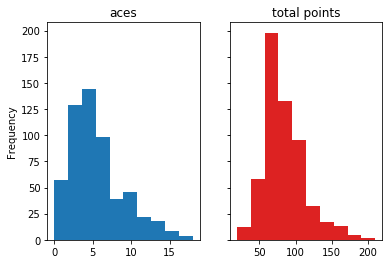

In [69]:
fig, axes = plt.subplots(1, 2, sharey=True)
df['player1 aces'].plot.hist(ax=axes[0], title='aces')
df['player1 total points won'].plot.hist(color='#dd2222', 
                                           ax=axes[1], title='total points');

## Exercise: plotting

Now let's plot the points won vs points aced to try and see if one can explain the other.

`scatter(x, y)` creates a scatterplot with columns `x` and `y` on axes x and y. 


Bonus points: `marker` and `alpha` keyword arguments control the marker shape and the transparency, use these arguments to plot with `.` instead of the default `o` and with tranparancy of 3/4.

Many more options are available through this [Pandas plotting API](http://pandas.pydata.org/pandas-docs/stable/visualization.html).

# Linear model

Can the number of aces by Novak provide a good predictor of the number of points he won?

The simplest model for such predictions is the linear model
$$
\widehat{y} = ax + b
$$
where here $x$ is the aces and $y$ is the points won.
The model parameters can be interpreted as follows:
- the intercept $b$ is the estimate for points won if 0 points were aced, and
- the slope $a$ is the estimate for the linear increase in points won for every additional ace.

How do we find suitable $a$ and $b$?
For a given $a$ and $b$, we mark the real points won as $y$ and calculate the distance between the predictions and the observed values.
We plot a histogram of these differences, called [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals).
Here, `bins` controls the number (if `int`) or locations (if `list`) of the histogram bins.

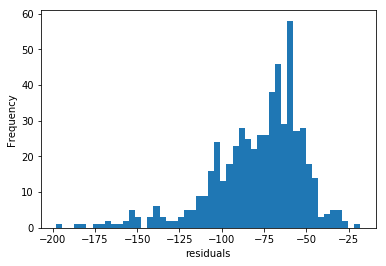

In [70]:
a = 1
b = 0

x = df['player1 aces']
y = df['player1 total points won']

yhat = a * x + b
residuals = yhat - y

residuals.plot.hist(bins=50)
plt.xlabel('residuals');

# Maximum likelihood & least squares

In the simplest form of linear modeling, we assume that the residuals (the distance between our prediction and the observed values) has a [normal (or Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution). 
However, this assumption is not a must, and the framework of [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) allow us to replace the normal distribution with other distributions such as the binomial distribution (which might be more suitable in this case, in which y values are integers).
We'll talk about it again later.

Usually, when we speak about probabilities, we ask *"what is the probability to see this data given this model"* - when I say "model" I mean something like $y=ax+b$ with given values for $a$ and $b$, such as $a=1$ and $b=0$, and a normal distribution of errors, $\widehat{y}-y \sim Normal(0, \sigma^2)$ where $\sigma^2$ is the variance of the distribution.
That is, we want to say something about expected data given a model.

For example, given this model ($y=x$), if $x=1$ then the probability for $y=1.1$ is:
$$
f(0.1) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{0.1^2}{2\sigma^2}\bigg),
$$
and in general, the probability for a deviance of size $\widehat{y}-y$ is
$$
f(z) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{(\widehat{y}-y)^2}{2\sigma^2}).
$$

But in cases where we have data and we try to say something about the expected model given observed data.
This is where *likelihood* comes into place, and its definition is straight-forward:
The likelihood of the model $ax+b - \widehat{y} \sim Normal(0, \sigma^2)$ given observed data $(x,y)$ is the probability of seeing data $(x,y)$ given the model $ax+b - \widehat{y} \sim Normal(0, \sigma^2)$.
If we have mutliple data points (we do!) we just multiply all of them under the assumption that each data point (here, game point, so.. confusing) is *independent* (in the probability sense of independence, that is, knowing what happened in one of them doesn't change the probability of the other one occuring).

So the likelihood of the model $ax+b - \widehat{y} \sim Normal(0, \sigma^2)$ given data points $(x_i, y_i)$, where $i$ indexes the point, is
$$
\mathbf{L}(a,b | x_i, y_i) = (2 \pi \sigma^2)^{-n/2} \prod_{i=1}^{n}{ exp\bigg(-\frac{(ax_i+b-y_i)^2}{2\sigma^2}\bigg)}
$$

After establishing what likelihood is, we can ask "what are the parameters $a$ and $b$ that maximize the model likelihood. 
This is akin to asking what are $a$ and $b$ for which the probability of seeing the data we saw is maximized.
This approach is called **maximum likelihood**.

Now, our likelihood $\mathbf{L}$ is a product of exponents, so we can take the log-likelihood (literally the log of the likelihood) to get a simpler expression
$$
\log\mathbf{L} = \\
\log (2 \pi \sigma^2)^{-n/2} + \log{\prod_{i=1}^{n}{ exp\bigg(-\frac{(ax_i+b-y_i)^2}{2\sigma^2}\bigg)}} = \\
-\frac{n}{2}\log{(2 \pi \sigma^2)} + \sum_{i=1}^{n}{-\frac{(ax_i+b-y_i)^2}{2\sigma^2}} = \\
-\frac{n}{2}\log{(2 \pi \sigma^2)} - \frac{1}{2\sigma^2} \sum_{i=1}^{n}{(ax_i+b-y_i)^2}
$$

Note that 
- $\log{\mathbf{L}}$ is an increasing function of $\mathbf{L}$ so maximizing the log-likelihood is equivalent to maximizing the likelihood
- $a$ and $b$ only appear in the sum-of-squares, which is prepended by a negative sign, so minimizing the sum-of-squares is equivalent to maximizing the log-likelihood
- if we only care about the best estimate of $a$ and $b$ then we don't really care about the variance $\sigma^2$ (we would care if we wanted to have some statistical measure of precision or confidence)

This is where the **least squares** approach comes from -- when assuming a model with normal distribution of residuals, maximizing the likelihood is equivalent to minimizing the sum-of-squares of the residials, or the deviances between the model prediction $\widehat{y}$ and the truth $y$.
Note that this works with non-linear models just the same, as long as the residuals are normally and independently distributed.

In ths case of a linear model there is a formula to find $a$ and $\sigma^2$ when $b=0$, but since we will later deal with cases in which there is no formula, let's continue as if there is no formula.

Let's calculate the sum-of-squares. 
Note that Pandas aggregation methods (such as `sum` or `mean`) ignore NaN values, but this is not always the case in other numerical packages.

In [71]:
(residuals**2).sum()

3942816.0

## Exercise: sumsquares

Write a function that calculates the sum-of-squares for some $a$ and $b$ values and the data $x,y$:

Now we would like to find $a$ and $b$ that minimize the function `sumsquares`.

# Gradient descent

One way to do this is with *gradient descent*.
This is an iterative algorithm.
In each step, we calculate that gradient of the function respect to $a$ and $b$ (the gradient is just the vector of derivatives):
$$
\frac{d\Sigma}{da} = \sum_{i=1}^{n}{2ax^2 +2bx -2xy} \\
\frac{d\Sigma}{db} = \sum_{i=1}^{n}{2ax +2b-2y} \\
$$
and "descend" (minimize) the function just a tiny bit by updating $a$ and $b$ in the oppositve direction of the gradient:
$$
a_t = a_{t-1} - \frac{d\Sigma}{da} \eta \\ 
b_t = b_{t-1} - \frac{d\Sigma}{db} \eta \\ 
$$
where $\eta$ is the size of the step we take (the "tiny bit"), also sometimes called the *learning rate*. We'll talk later about methods in which this rate can be learned or adjusted over time.

Let's try it!


In [72]:
def gradient_descent(a, b, x, y, eta=0.00001):
    dyda = (2*a*x**2 + 2*b*x -2*x*y).sum()
    dydb = (2*a*x + 2*b - 2*y).sum()
    return a - eta * dyda, b - eta * dydb

The last technical details is the stopping condition.
We'll set the gradient descent to stop when the relative difference between the sum of squares of two iterations is less than 0.01.

In [73]:
def linear_model(x, y, a=0, b=0, rel_err=1e-2):    
    t = 0
    S_, S = np.inf, 0
    while abs(S - S_) > rel_err:
        t += 1
        a, b = gradient_descent(a, b, x, y)
        if t % 100 == 0:            
            S_, S = S, sumsquares(a, b, x, y)
            print("{}: S={:.6f}, a={:.4f}, b={:.4f}".format(t, S, a, b))
    return a, b

In [75]:
a, b = linear_model(x, y)

100: S=734376.862702, a=9.4985, b=19.4026
200: S=564584.058417, a=7.8145, b=32.2764
300: S=476309.394005, a=6.6002, b=41.5589
400: S=430415.715471, a=5.7246, b=48.2519
500: S=406555.758105, a=5.0933, b=53.0779
600: S=394151.052627, a=4.6381, b=56.5576
700: S=387701.891146, a=4.3099, b=59.0665
800: S=384348.995434, a=4.0732, b=60.8756
900: S=382605.837088, a=3.9026, b=62.1800
1000: S=381699.575373, a=3.7795, b=63.1206
1100: S=381228.413187, a=3.6908, b=63.7987
1200: S=380983.457673, a=3.6269, b=64.2877
1300: S=380856.106187, a=3.5807, b=64.6403
1400: S=380789.896610, a=3.5475, b=64.8945
1500: S=380755.474491, a=3.5235, b=65.0778
1600: S=380737.578556, a=3.5062, b=65.2100
1700: S=380728.274524, a=3.4938, b=65.3053
1800: S=380723.437392, a=3.4848, b=65.3740
1900: S=380720.922584, a=3.4783, b=65.4235
2000: S=380719.615144, a=3.4736, b=65.4592
2100: S=380718.935411, a=3.4702, b=65.4850
2200: S=380718.582021, a=3.4678, b=65.5036
2300: S=380718.398294, a=3.4661, b=65.5170
2400: S=380718.30277

# Plot and interpret a linear model

Let's plot the results.
We now load the [matplotlib](http://matplotlib.org) library to use it to plot a straight line over the scatterplot. Note that we sort the x values first otherwise the straight line will zigzag over the plot.

a=3.462412091384354, b=65.54483381549923


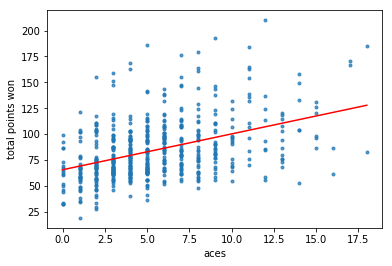

In [76]:
def plot_linear_model(a, b, x, y, **plot_kws):
    plt.scatter(x, y, marker='.', alpha=0.75)
    x_ = x.sort_values()
    plt.plot(x_, a * x_ + b, '-r', **plot_kws)
    plt.xlabel('aces')
    plt.ylabel('total points won')
    print("a={}, b={}".format(a, b))
    
plot_linear_model(a, b, x, y);

The results can be interpreted as follows
- without any aces, Novak wins ~65 points. 
- for any additional ace, he wins an additional ~3.5 point (more than the one point given by the ace)

This model will probably do a good job at *interpolation*, that is estimating $\widehat{y}$ for $x$ values that are within the original $x$ values, but not at *extrapolation*.
For example, if Novak aces all the points in a game, he can't wint 3.5 times the points he aced!

# Outliers

There are some point that might be outliers - all those games with more than 15 aces. 
It's important to check how much they affect the results.

Let's slice $x$ and $y$ to take only those games with less than 15 aces.

In [77]:
y_ = y[x < 15]
x_ = x[x < 15]

and run the analysis again:

In [78]:
a_, b_ = linear_model(x_, y_)

100: S=701164.526040, a=10.1984, b=17.9652
200: S=551573.224563, a=8.4945, b=30.0416
300: S=468482.678960, a=7.2246, b=39.0419
400: S=422330.003635, a=6.2781, b=45.7497
500: S=396694.482479, a=5.5727, b=50.7489
600: S=382455.222452, a=5.0470, b=54.4748
700: S=374546.020025, a=4.6552, b=57.2516
800: S=370152.850512, a=4.3632, b=59.3211
900: S=367712.662827, a=4.1456, b=60.8635
1000: S=366357.259644, a=3.9834, b=62.0131
1100: S=365604.400428, a=3.8625, b=62.8698
1200: S=365186.224489, a=3.7724, b=63.5083
1300: S=364953.948503, a=3.7052, b=63.9841
1400: S=364824.930718, a=3.6552, b=64.3388
1500: S=364753.267740, a=3.6179, b=64.6031
1600: S=364713.462512, a=3.5901, b=64.8001
1700: S=364691.352683, a=3.5694, b=64.9469
1800: S=364679.071769, a=3.5540, b=65.0563
1900: S=364672.250331, a=3.5425, b=65.1379
2000: S=364668.461361, a=3.5339, b=65.1987
2100: S=364666.356776, a=3.5275, b=65.2440
2200: S=364665.187784, a=3.5227, b=65.2777
2300: S=364664.538466, a=3.5192, b=65.3029
2400: S=364664.1778

a=3.462412091384354, b=65.54483381549923


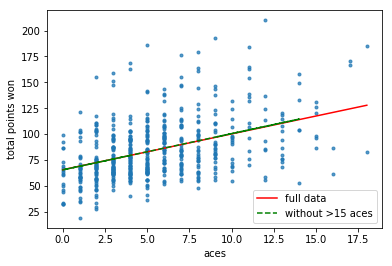

In [79]:
plot_linear_model(a, b, x, y)
plt.plot(x_, b_ + a_ * x_,  ls='--', color='g')
plt.legend(['full data', 'without >15 aces']);

It seems that in this case the outliers did not have a very significant effect on the analysis: we got similar values for $a$ and $b$.

There are many different ways to handle outliers in linear models, see for examples `statsmodels`'s [robust linear models](http://www.statsmodels.org/stable/rlm.html) module.

# Exercise: Federer

Redo the analysis but for Roger Federer and instead of using aces, use double faults.

# Off-the-shelf solutions

Let's see how we could have done this with Python's packages instead of reinventing the wheel.

We'll work with NumPy and SciPy, the numerical and scientific backbone of scientific Python.

NumPy and SciPy don't like NaNs, which we have a lot. We can fliter them with `np.isfinite` or just by taking only the non-negative values (NaN are not negative but are also not non-negative).

In [43]:
y = y[x>=0]
x = x[x>=0]

## NumPy

First method is NumPy's `polyfit` which fits a polynomial of specified degree to the data; in this case we want degree one. It returns the coefficients of the polynomial, which we could feed to `np.poly1d` to create a callable polynomial object.

In [44]:
a_np, b_np = np.polyfit(x, y, 1)
print(a_np, b_np)

3.46152962272 65.5515796967


Note how much faster NumPy does it.
This is because under-the-hood NumPy calls native code (C/Fortran).
The main drain of calculation time is probably the `while` loop in `linear_model` as each iteration performs redundent type check etc.

In [23]:
%timeit -n 1 -r 1 linear_model(x, y)
%timeit np.polyfit(x, y, 1)

1.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
162 µs ± 8.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## SciPy
Next is SciPy's statistics package with its linear regression method, which basically uses the same method `polyfit` does (i.e. exact same result) but then also calculates some statistics.

In [45]:
res = scipy.stats.linregress(x, y)
print(res.slope, res.intercept)

3.46152962272 65.5515796967


The P-value gives the probability to get this data if the null hypothesis is right; in this case, the null hypothesis is $a=0$.

The r-value is the [coefficient of correlation](https://en.wikipedia.org/wiki/Correlation_coefficient).

In [46]:
print('r={}, P={}'.format(res.rvalue, res.pvalue))

r=0.4235692130211395, P=5.27863045781742e-26


# statsmodels

This package focuses on statistical modeling, and as such, provides a full statistical analysis of the linear model.

Note that here `y` comes before `x`.

In [58]:
import statsmodels.api as sm

In [49]:
X = sm.add_constant(x) # for intercept
results = sm.OLS(y, X).fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     player1 total points won   R-squared:                       0.179
Model:                                  OLS   Adj. R-squared:                  0.178
Method:                       Least Squares   F-statistic:                     123.1
Date:                      Sun, 08 Apr 2018   Prob (F-statistic):           5.28e-26
Time:                              12:36:33   Log-Likelihood:                -2641.6
No. Observations:                       565   AIC:                             5287.
Df Residuals:                           563   BIC:                             5296.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

With `statsmodels` it is easy to use [generalized linear models](http://www.statsmodels.org/stable/glm.html) (GLM) to change the probability distribution.

For example, since `y` is an integer, it might be better to use the Poisson distribution:

In [59]:
poi_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poi_results.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     player1 total points won   No. Observations:                  565
Model:                                  GLM   Df Residuals:                      563
Model Family:                       Poisson   Df Model:                            1
Link Function:                          log   Scale:                             1.0
Method:                                IRLS   Log-Likelihood:                -3869.1
Date:                      Sun, 08 Apr 2018   Deviance:                       4223.3
Time:                              12:38:50   Pearson chi2:                 4.43e+03
No. Iterations:                           4                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.2160      0.009    489.118      0.000       4.199     

The log-likelihhod using Poisson is much lower than using normal distribution, which means that it is probably a better choice. The coefficients, though, are on a different scale because when using the Poisson distribution we assumed that $\log(y) = ax + b$ rather than $y=ax+b$ (here the $\log$ function is the *link function*).

Nomral  a=3.462, b=65.552
Poisson a=1.039, b=67.759


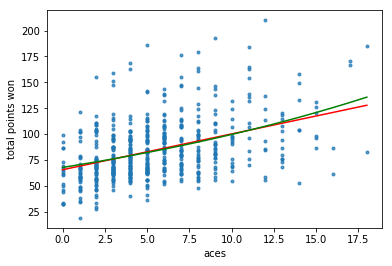

In [60]:
plt.scatter(x, y, marker='.', alpha=0.75)
x_ = x.sort_values()

b, a = results.params
yhat = b + a*x_
plt.plot(x_, yhat, '-r')
print("Nomral  a={:.3f}, b={:.3f}".format(a, b))

b, a = poi_results.params
yhat = np.exp(a * x_ + b)
plt.plot(x_, yhat, '-g')
plt.xlabel('aces')
plt.ylabel('total points won')
print("Poisson a={:.3f}, b={:.3f}".format(np.exp(a), np.exp(b)))

This is interesting, because you can see that using the Poisson linear model, the effect of an additinal ace is roughly an additional point, not 3.5 points; the number of points won without aces is roughly the same.

The plots are very similar for the majority of the range, so the nomral model was probably pretty good as a predictive model, but not so much as descriptive model.
Moreover, at the ends of the range (<2.5 aces, >12.5 aces) the Poisson model will probably outperform the normal model.

# seaborn

Another important package is `seaborn`, a statistical visualization package, which allows us to rapidly create statistical visualization (!).

For example, `regplot` is a function for creating a scatter plot with a linear model, including a confidence interval around the line (generated using bootstrap, a resampling approach, where you basically randomly choose data points many times and see where does the linear model fall in most of the cases).

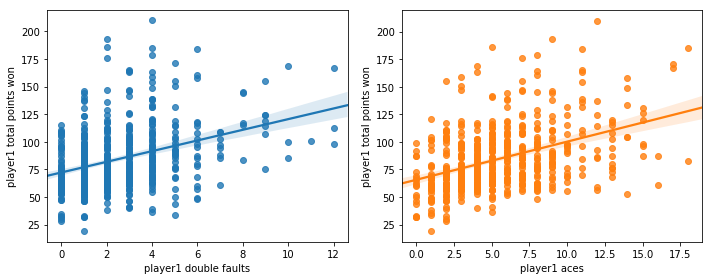

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.regplot('player1 double faults', 'player1 total points won', data=df, ax=axes[0])
sns.regplot('player1 aces', 'player1 total points won', data=df, ax=axes[1])
fig.tight_layout()

We can also plot the joint distribution of two variables to see how they are distributed together:

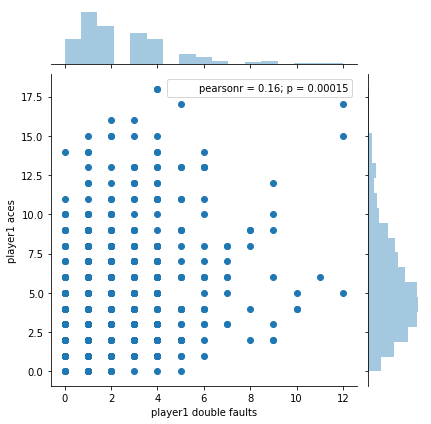

In [62]:
sns.jointplot('player1 double faults', 'player1 aces', data=df);

Of course there are many more twists to add, such as regularization, outlier detection, and linking functions - we'll do the latter in the next session when we deal with the classical classification method, *logistic regression*.

# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.1**.
- Allen B. Downey, 2014. [Think Stats: Probability and Statistics for Programmers.](http://www.greenteapress.com/thinkstats2/index.html) (Available for free online).
- Cyrille Rossant, 2014. [IPython Interactive Computing and Visualization Cookbook](https://ipython-books.github.io/cookbook/) (the Tennis data is borrowed from there).
- Illustrate distributions using the [Seeing Theory](http://students.brown.edu/seeing-theory/probability-distributions/index.html#section2) webpage.
- Explore how regression is affected by outliers using the [Seeing Theory](http://students.brown.edu/seeing-theory/regression-analysis/index.html#section1) webpage.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)